### Index 
1. [Loading Training Data](#loading-data)
2. [Target Label Analysis](#network-latency-description)
3. [Group Similar Graphs](#group-data-by-their-similarity)
4. [Creating Dataset](#generating-un-biased-dataset)
5. [Model Inference Code](#model-inference-functions)
6. [Validating Task Network](#validating-task-problem)
7. [Mapping Graph Code](#mapping-graph-function)

### Loading Data
Data is loaded as list of dictionaries

In [2]:
import os 
import pickle 
from natsort import natsorted

def load_data_as_dict(directory_path):
    """
    Return pickle file in directory_path as a list. 
    Also returns a list of all the unique id's in the dataset. 
    Why do we need unique id? 
        Lets say a task is randomly mapped 100 times. 
        All the 100 data (dict in pickle file) will have the same id. 
        So it is easier to retrieve all the mapping for a single task
    """
    entries = os.listdir(directory_path)
    files = natsorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

    list_of_dicts = []
    list_of_uuids = []

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, 'rb') as file:
            data_dict = pickle.load(file)
            list_of_dicts.append(data_dict)

            uuid = data_dict['task_dag'].id

            if uuid not in list_of_uuids:
                list_of_uuids.append(uuid)

    return list_of_dicts, list_of_uuids

In [3]:
# data_98k, _ = load_data_as_dict('data/task_7_98k')
data_209k, _ = load_data_as_dict('data/task_7')
# print(f"Total size of dataset {len(data_98k) + len(data_209k)}")

In [ ]:
def get_single_dataset(list_of_data):
    """
    Returns a single dataset from the list of datasets. 
    """
    single_dataset = []
    for data in list_of_data:
        single_dataset.extend(data)
    return single_dataset

dataset = get_single_dataset([data_209k])

In [ ]:
# Save the dataset as pickle
with open('data/dataset_307k.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [98]:
# Load the pickle dataset
dataset = pickle.load(open('data/dataset_307k.pkl', 'rb'))

### Network Latency Description 

In [99]:
import pandas as pd 
df = pd.DataFrame(dataset)
df['network_processing_time'] = pd.to_numeric(df['network_processing_time'])
df['network_processing_time'].describe()

count    307409.000000
mean       2171.958232
std         383.570140
min        1027.000000
25%        2010.000000
50%        2099.000000
75%        2406.000000
max        3787.000000
Name: network_processing_time, dtype: float64

In [100]:
df_min = df[df['network_processing_time'] == df['network_processing_time'].min()]
print(f"Size of min {len(df_min)}")
df_max = df[df['network_processing_time'] > 3700]
print(f"Size of max {len(df_max)}")

list_of_low_latency_graph = df_min['task_dag'].to_list()
list_of_low_latency_map = df_min['map'].to_list()

list_of_low_latency= []
for graph, map in zip(list_of_low_latency_graph, list_of_low_latency_map):
    list_of_low_latency.append((graph, map))

list_of_high_latency_graph = df_max['task_dag'].to_list()
list_of_high_latency_map = df_max['map'].to_list()

list_of_high_latency= []
for graph, map in zip(list_of_high_latency_graph, list_of_high_latency_map):
    list_of_high_latency.append((graph, map))

print(list_of_high_latency)
print(list_of_low_latency)

Size of min 13
Size of max 4
[(<utils.DAG_Generator.DAG object at 0x7fc1f55d35b0>, {0: 26, 1: 24, 2: 31, 3: 17, 4: 21, 5: 25, 6: 27, 7: 20, 8: 16}), (<utils.DAG_Generator.DAG object at 0x7fc10005fd90>, {0: 18, 1: 17, 2: 26, 3: 19, 4: 31, 5: 27, 6: 23, 7: 30, 8: 24}), (<utils.DAG_Generator.DAG object at 0x7fc04cbb4c70>, {0: 19, 1: 22, 2: 29, 3: 23, 4: 21, 5: 16, 6: 24, 7: 18, 8: 30}), (<utils.DAG_Generator.DAG object at 0x7fc045122490>, {0: 18, 1: 19, 2: 31, 3: 24, 4: 28, 5: 25, 6: 17, 7: 23, 8: 22})]
[(<utils.DAG_Generator.DAG object at 0x7fc1fa1e29a0>, {0: 27, 1: 23, 2: 31, 3: 25, 4: 24, 5: 29, 6: 16, 7: 22, 8: 18}), (<utils.DAG_Generator.DAG object at 0x7fc1fa0189a0>, {0: 22, 1: 23, 2: 30, 3: 19, 4: 16, 5: 31, 6: 20, 7: 27, 8: 26}), (<utils.DAG_Generator.DAG object at 0x7fc14cb00850>, {0: 29, 1: 30, 2: 25, 3: 20, 4: 17, 5: 23, 6: 24, 7: 26, 8: 27}), (<utils.DAG_Generator.DAG object at 0x7fc13e8b3850>, {0: 26, 1: 22, 2: 30, 3: 28, 4: 27, 5: 29, 6: 17, 7: 18, 8: 19}), (<utils.DAG_Gener

### Group data by their similarity 
Similarity is measured by checking graph isomorphism

In [ ]:
from networkx.algorithms.isomorphism import GraphMatcher

"""
Two graphs which contain the same number of 
graph vertices connected in the same way 
are said to be isomorphic. 
"""
def isomorphic(graph1, graph2):
    GM = GraphMatcher(graph1, graph2)
    return GM.is_isomorphic()

def group_by_isomorphism(data):
    """
    Check if two graphs in data is isomorphic, 
    if they are, put them into the same list. 

    Returns 
        1. isomorphic_groups contains the list of all similar graphs. (not usefule for us). But is useful in the algo.
        2. list_of_same_graphs (self explanatory)
    """
    isomorphic_groups = []
    list_of_same_graphs = []

    for item in data:

        if isinstance(item, dict): 
            graph = item['task_dag'].graph

        else: 
            graph = item

        added_to_group = False
        
        # Iterate through existing isomorphic groups
        for existing_group, existing_data_group in zip(isomorphic_groups, list_of_same_graphs):
            if isomorphic(graph, existing_group[0]):
                existing_group.append(graph)
                existing_data_group.append(item)
                added_to_group = True
                break

        if not added_to_group:
            # If no isomorphic group found, create a new one
            isomorphic_groups.append([graph])
            list_of_same_graphs.append([item])

    return isomorphic_groups, list_of_same_graphs

_, list_of_same_graphs = group_by_isomorphism(dataset)


"""
list_of_same_graphs.
Each unique graph is a list with all its occurences
"""
print("Number of Unique Tasks", len(list_of_same_graphs))

In [ ]:
# Save the list_of_same_graphs as pickle
with open('data/list_of_same_graphs.pkl', 'wb') as f:
    pickle.dump(list_of_same_graphs, f)

In [101]:
# Load the list_of_same_graphs from pickle 
list_of_same_graphs = pickle.load(open('data/list_of_same_graphs.pkl', 'rb'))

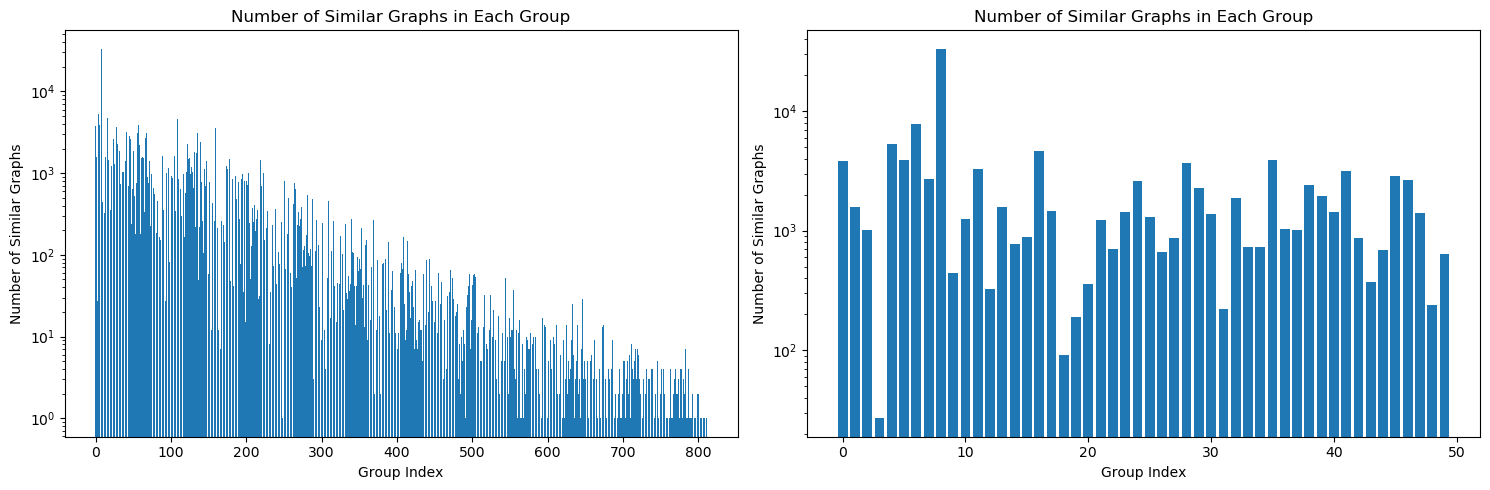

In [102]:
num_similar_graph = [len(group) for group in list_of_same_graphs] 
# print("Number of similar graphs for each unique task:", num_similar_graph)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first graph on the first subplot
axs[0].bar(range(len(num_similar_graph)), num_similar_graph)
axs[0].set_yscale('log')
axs[0].set_xlabel('Group Index')
axs[0].set_ylabel('Number of Similar Graphs')
axs[0].set_title('Number of Similar Graphs in Each Group')

# Plot the second graph on the second subplot
num_similar_graph = num_similar_graph[0:50]
axs[1].bar(range(len(num_similar_graph)), num_similar_graph)
axs[1].set_yscale('log')
axs[1].set_xlabel('Group Index')
axs[1].set_ylabel('Number of Similar Graphs')
axs[1].set_title('Number of Similar Graphs in Each Group')

plt.tight_layout()
plt.show()

Index of the group with the maximum occurrences: 8


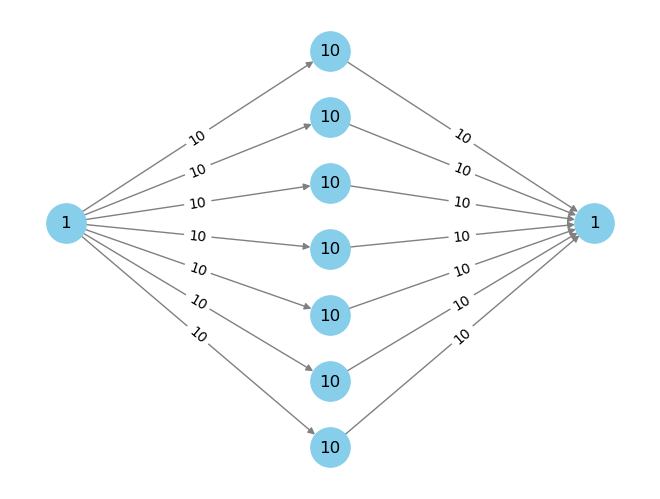

Min: 2665.0, Max: 3613.0
25th Percentile 2676.0
75th Percentile 2962.0
Inter quartile range: 286.0


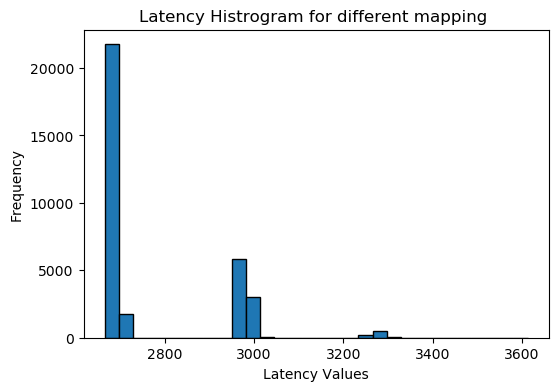

In [103]:
max_occurrences_index = num_similar_graph.index(max(num_similar_graph))
print("Index of the group with the maximum occurrences:", max_occurrences_index)

most_freq_graph_list = list_of_same_graphs[max_occurrences_index]
most_freq_graph_list[0]['task_dag'].plot()

import numpy as np

def plot_latency_histogram(graph_list, fig_width=6, fig_height=4):
    latency_list = []

    for task in graph_list:
        latency = task['network_processing_time']
        latency_list.append(float(latency))

    q1 = np.percentile(latency_list, 25)
    q2 = np.percentile(latency_list, 75)

    print(f"Min: {np.min(latency_list)}, Max: {np.max(latency_list)}")
    print(f"25th Percentile {q1}")
    print(f"75th Percentile {q2}")
    print(f"Inter quartile range: {q2-q1}")

    plt.figure(figsize=(fig_width, fig_height))
    plt.hist(latency_list, bins=30, edgecolor='black')
    plt.title('Latency Histrogram for different mapping ')
    plt.xlabel('Latency Values')
    plt.ylabel('Frequency')
    plt.show()

plot_latency_histogram(most_freq_graph_list)


### Generating un-biased dataset 
During data inspection, it was observed that some graph structures dominate the dataset. To not have a biased training dataset, there is an upper limit to which a certain kind of graph (task) can exist. With this upper-limit constraint, a training dataset is created. 

In [ ]:
"""
Creating Training Dataset 
    Make sure, each graph is not occuring more than 1000 time. 
"""

training_dataset = []
for graph_list in list_of_same_graphs:
    for idx, data in enumerate(graph_list):
        if (idx+1) == 1000: break
        training_dataset.append(data)

print(f"Final Size of Training Dataset is {len(training_dataset)}")
print(type(training_dataset[0]))

In [ ]:
directory_path = 'data/training_data'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")

for index, data_item in enumerate(training_dataset):
    file_name = f"data_{index + 1}.pkl"
    file_path = os.path.join(directory_path, file_name)
    with open(file_path, 'wb') as file:
        pickle.dump(data_item, file)
        # print(f"Data saved to '{file_path}' successfully.")

### Mapping Graph Function 

In [104]:
import networkx as nx
import matplotlib.pyplot as plt
from bidict import bidict

def xy_routing(source, target):
    """
        1. Determine the step for the X direction (1 if source is left of target, -1 if it's right)
        2. Move in the X direction
        3. Update source to the last point in the X direction
        4. Determine the step for the Y direction (1 if source is below target, -1 if it's above)
        5. Move in the Y direction

        Returns a list of (x, y) coordinates from source to target
    """
    path = []
    step_x = 1 if source[0] <= target[0] else -1
    for x in range(source[0], target[0] + step_x, step_x):
        path.append((x, source[1]))
    source = path[-1]
    step_y = 1 if source[1] <= target[1] else -1
    for y in range(source[1] + step_y, target[1] + step_y, step_y):
        path.append((target[0], y))
    return path

def get_nework_path(source_mapped, target_mapped, pe_net, router_net): 
    """
    Arg: (source, target) is the element of edge_index list 
    Function: 
        1. Maps the PE to the router
        2. Finds the XY path from source to target in coordinate-space
           Using XY routing algorithm
        3. Then converts the path from coordinate-space to PE-space

    return a list of nodes in the path from source to target in PE-space. 
    """
    source_xy = pe_net[source_mapped]
    target_xy = pe_net[target_mapped]
    xy_path = xy_routing(source_xy, target_xy)
    node_path = []
    for xy_node in xy_path:
        node_path.append(router_net.inverse[xy_node])
    node_path.insert(0, pe_net.inverse[source_xy])
    node_path.append(pe_net.inverse[target_xy])
    return node_path

def create_edge_index(node_path_list):
    """
    Given a list of node paths, create a list of edges suitable for creating a graph
    """
    edge_index = []
    weights = []
    for node_path in node_path_list:
        for idx, node in enumerate(node_path):
            if idx == len(node_path) - 1:
                break
            edge = (node, node_path[idx+1])

            # if edge not in edge_index:
            edge_index.append(edge)
            weights.append(1.0)

            # else: 
            #     idx = edge_index.index(edge)
            #     weights[idx] += 1.0


    return edge_index, weights

def convert_edge_index(edge_index, num_of_tasks):
    """
    Changes the Start and Exit nodes to 0 and num_of_tasks respectively
    """
    converted_edge_index = []
    node_mapping = {'Start': 0, 'Exit': num_of_tasks}

    for src, dest in edge_index:
        if src == 'Start':
            src = node_mapping[src]

        if dest == 'Exit':
            dest = node_mapping[dest]

        converted_edge_index.append((src, dest))

    return converted_edge_index


def get_mapped_graph(edge_index, map, pe_net, router_net):
    """
    Takes in Task Graph and returns the mapped graph
    """
    node_path_list = []
    for edge in edge_index:
        
        source_mapped = map[edge[0]]
        target_mapped = map[edge[1]]
        node_path = get_nework_path(source_mapped, target_mapped, pe_net, router_net)
        node_path_list.append(node_path)

    new_edge_index, weights = create_edge_index(node_path_list)
    # print(f"New Edge Index: {new_edge_index}")
    # print(f"Wegihts: {weights}")

    graph = nx.MultiDiGraph()
    # graph.add_nodes_from(new_edge_index)
    for (src, dest), weight in zip(new_edge_index, weights):
        # graph.add_edge(src, dest)
        if (src, dest) in graph.edges:
            max_rad = max(x[2]['rad'] for x in graph.edges(data=True) if sorted(x[:2]) == sorted([src,dest]))
        else:
            max_rad = 0
        graph.add_edge(src, dest, rad=max_rad+0.1)

    return graph

def rename_nodes(graph):
    mapping = {}
    for idx, old_label in enumerate(graph.nodes()):
        new_label = idx
        mapping[old_label] = new_label

    new_graph = nx.relabel_nodes(graph, mapping)
    return new_graph


def add_node_feature(graph, pe_net):
    for node in graph.nodes():
        graph.nodes[node]['type'] = 1.0 if node in pe_net.keys() else 0.0
    return graph 

from torch_geometric.utils import from_networkx
import torch

def get_torch_graph(graph, target):
    # graph_torch = from_networkx(graph, group_node_attrs=['type'], group_edge_attrs=['weight'])
    graph_torch = from_networkx(graph, group_node_attrs=['type'])
    graph_torch.y = torch.tensor([float(target)])
    return graph_torch


#### Example Condition

Graph edges are [(12, 3), (12, 3), (3, 4), (3, 4), (4, 13), (4, 5), (4, 1), (4, 1), (13, 4), (5, 14), (5, 4), (14, 5), (1, 10), (1, 10)]
Data(edge_index=[2, 14], rad=[14], x=[8, 1], y=[1])
Edge Index is 
tensor([[0, 0, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 6],
        [1, 1, 2, 2, 3, 4, 6, 6, 2, 5, 2, 4, 7, 7]])
Has isolated nodes: False
Has self loops: False
Is undirected: False


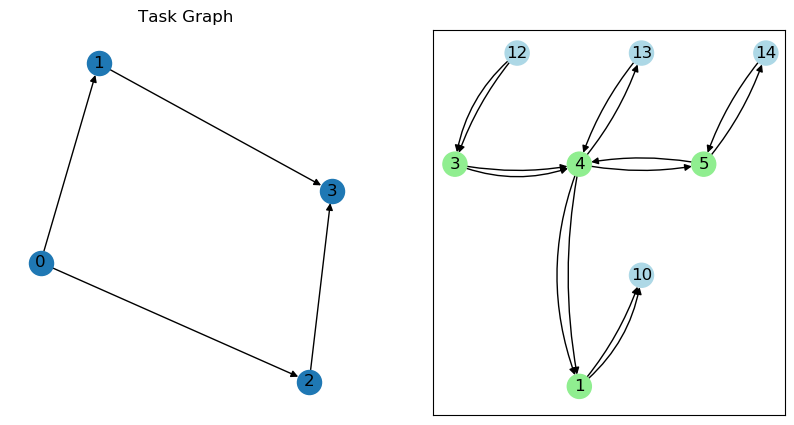

In [105]:
edge_index  = [
    (0, 1), 
    (0, 2), 
    (1, 3), 
    (2, 3)
]

map = {
    0: 12, 
    1: 13, 
    2: 14,
    3: 10
}

pe_3x3 = bidict({
    15: (0, 2), 16: (1, 2), 17: (2, 2),
    12: (0, 1), 13: (1, 1), 14: (2, 1),
    9 : (0, 0), 10: (1, 0), 11: (2, 0)
})

router_3x3 = bidict({
    6: (0, 2), 7: (1, 2), 8: (2, 2),
    3: (0, 1), 4: (1, 1), 5: (2, 1),
    0: (0, 0), 1: (1, 0), 2: (2, 0)
})

pos_network = bidict({
    6: (0, 2), 7: (1, 2), 8: (2, 2),
    3: (0, 1), 4: (1, 1), 5: (2, 1),
    0: (0, 0), 1: (1, 0), 2: (2, 0),

    15: (0.5, 2.5), 16: (1.5, 2.5), 17: (2.5, 2.5),
    12: (0.5, 1.5), 13: (1.5, 1.5), 14: (2.5, 1.5),
    9 : (0.5, 0.5), 10: (1.5, 0.5), 11: (2.5, 0.5)
})

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

G = nx.DiGraph(edge_index)
nx.draw(G, with_labels=True, ax=axs[0])
axs[0].set_title('Task Graph')

new_graph = get_mapped_graph(edge_index, map, pe_3x3, router_3x3)
print(f"Graph edges are {new_graph.edges()}")
node_colors = ["lightblue" if node in pe_3x3.keys() else "lightgreen" if node in router_3x3.keys() else "lightgray" for node in new_graph.nodes()]
nx.draw_networkx_nodes(new_graph, pos=pos_network, ax=axs[1], node_color=node_colors )
nx.draw_networkx_labels(new_graph, pos=pos_network, ax=axs[1])

for edge in new_graph.edges(data=True):
    nx.draw_networkx_edges(new_graph, pos_network, edgelist=[(edge[0],edge[1])], connectionstyle=f'arc3, rad = {edge[2]["rad"]}')

# edge_labels = {(src, dest): new_graph[src][dest]['weight'] for src, dest in new_graph.edges()}
# nx.draw_networkx_edge_labels(new_graph, pos=pos_network, edge_labels=edge_labels, ax=axs[1])

# print(edge_labels)
# axs[1].set_title('Mapped Graph')
# plt.show()

new_graph = add_node_feature(new_graph, pe_3x3)
graph_torch = get_torch_graph(new_graph, 100.0)

print(graph_torch)
print(f"Edge Index is \n{graph_torch.edge_index}")
print(f"Has isolated nodes: {graph_torch.has_isolated_nodes()}")
print(f"Has self loops: {graph_torch.has_self_loops()}")
print(f"Is undirected: {graph_torch.is_undirected()}")

#### Validating from Dataset

In [107]:
import random 

pe_4x4 = bidict({
28: (0, 3), 29: (1, 3), 30: (2, 3), 31: (3, 3),
24: (0, 2), 25: (1, 2), 26: (2, 2), 27: (3, 2),
20: (0, 1), 21: (1, 1), 22: (2, 1), 23: (3, 1),
16: (0, 0), 17: (1, 0), 18: (2, 0), 19: (3, 0)
})

router_4x4 = bidict({
12: (0, 3), 13: (1, 3), 14: (2, 3), 15: (3, 3),
8 : (0, 2), 9 : (1, 2), 10: (2, 2), 11: (3, 2),
4 : (0, 1), 5 : (1, 1), 6 : (2, 1), 7 : (3, 1),
0 : (0, 0), 1 : (1, 0), 2 : (2, 0), 3 : (3, 0)
})

pos_network = {
    12: (0, 3), 13: (1, 3), 14: (2, 3), 15: (3, 3),
    8 : (0, 2), 9 : (1, 2), 10: (2, 2), 11: (3, 2),
    4 : (0, 1), 5 : (1, 1), 6 : (2, 1), 7 : (3, 1),
    0 : (0, 0), 1 : (1, 0), 2 : (2, 0), 3 : (3, 0), 

    28: (0.5, 3.5), 29: (1.5, 3.5), 30: (2.5, 3.5), 31: (3.5, 3.5),
    24: (0.5, 2.5), 25: (1.5, 2.5), 26: (2.5, 2.5), 27: (3.5, 2.5),
    20: (0.5, 1.5), 21: (1.5, 1.5), 22: (2.5, 1.5), 23: (3.5, 1.5),
    16: (0.5, 0.5), 17: (1.5, 0.5), 18: (2.5, 0.5), 19: (3.5, 0.5)
}

random_index = 65
random.seed(11)
random_mapping_list = random.sample(list_of_same_graphs[random_index], 2)


def draw_mapped_graph(mapped_graph): 
    plt.figure(figsize=(10, 10))
    # pos = nx.spring_layout(mapped_graph, seed=200)
    node_colors = ["lightblue" if node in pe_4x4.keys() else "lightgreen" if node in router_4x4.keys() else "lightgray" for node in mapped_graph.nodes()]
    nx.draw_networkx(mapped_graph, pos=pos_network, with_labels=True, node_color=node_colors, connectionstyle='arc3, rad = 0.1')

    edge_labels = {(src, dest): mapped_graph[src][dest]['weight'] for src, dest in mapped_graph.edges()}
    nx.draw_networkx_edge_labels(mapped_graph, pos=pos_network, edge_labels=edge_labels)

    plt.title('Mapped Graph')
    plt.show()

# Example 1 
task_1 = random_mapping_list[0]

def convet_to_tensor(data):
    target = data['network_processing_time']

    task_edge_index = convert_edge_index(
        data['task_dag'].graph.edges, 
        (len(data['task_dag'].graph.nodes) - 1)
    )

    mapped_graph = get_mapped_graph(task_edge_index, data['map'], pe_4x4, router_4x4)
    mapped_graph = add_node_feature(mapped_graph, pe_4x4)
    return get_torch_graph(mapped_graph, target)


# task_1['task_dag'].plot(show_node_attrib=False)
# task_1_output = task_1['network_processing_time']

# task_1_edge_index = convert_edge_index(
#     task_1['task_dag'].graph.edges, 
#     (len(task_1['task_dag'].graph.nodes) - 1)
# )

# mapped_graph_1 = get_mapped_graph(task_1_edge_index, task_1['map'], pe_4x4, router_4x4)

# draw_mapped_graph(mapped_graph_1)
# print(f"Mapping is {task_1['map']}")
# print(f"Task Edge Index is {task_1_edge_index}")
# print(f"Map Edge Index is {mapped_graph_1.edges}")
# print(f"Latency is {task_1_output}\n")
# mapped_graph_1 = add_node_feature(mapped_graph_1, pe_4x4)
# task_1_torch = get_torch_graph(mapped_graph_1, task_1_output)

# print(task_1_torch)
# print(task_1_torch.x.t())

# convet_to_tensor(task_1).y

### Analyzing Network of Low Latency and High Lateny 

--------- High Latency ---------

Iter: 0, Mapping is {0: 26, 1: 24, 2: 31, 3: 17, 4: 21, 5: 25, 6: 27, 7: 20, 8: 16}


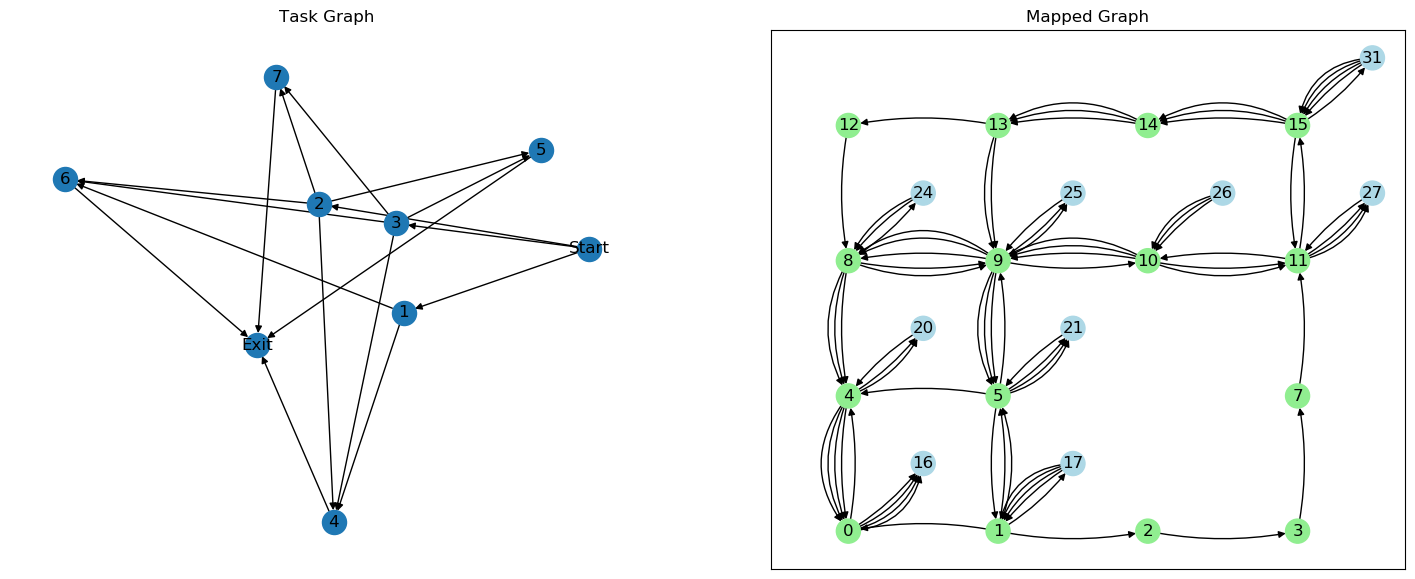


Iter: 1, Mapping is {0: 18, 1: 17, 2: 26, 3: 19, 4: 31, 5: 27, 6: 23, 7: 30, 8: 24}


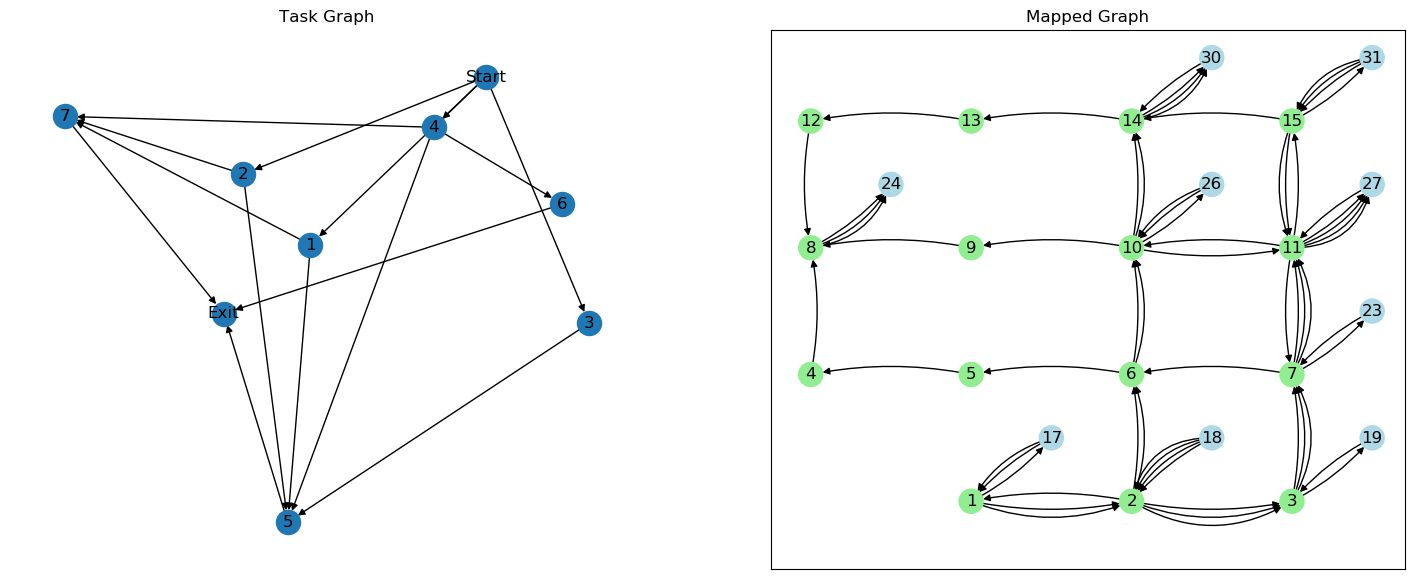

--------- Low Latency ---------

Iter: 0, Mapping is {0: 27, 1: 23, 2: 31, 3: 25, 4: 24, 5: 29, 6: 16, 7: 22, 8: 18}


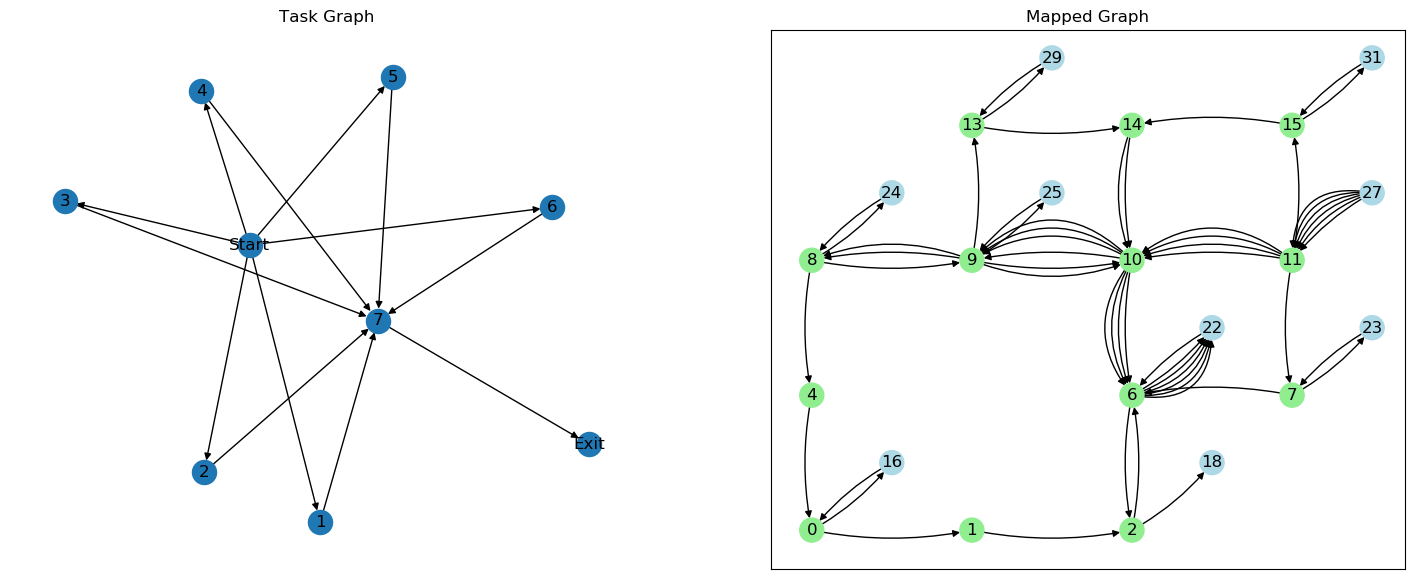


Iter: 1, Mapping is {0: 22, 1: 23, 2: 30, 3: 19, 4: 16, 5: 31, 6: 20, 7: 27, 8: 26}


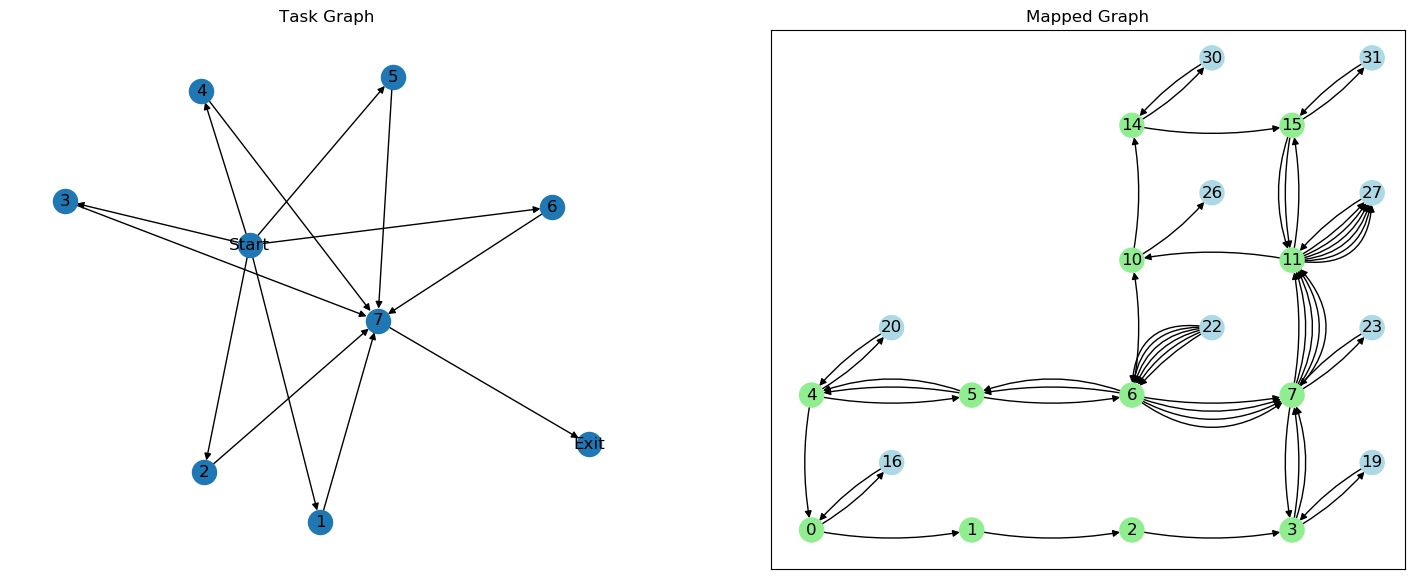

In [108]:
def show_task_and_map(graph, map, pe_net, router_net):
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    G = nx.DiGraph(graph)
    pos = nx.spring_layout(G, seed=200)
    nx.draw(G, pos=pos,with_labels=True, ax=axs[0])
    axs[0].set_title('Task Graph')

    graph_edge_index = convert_edge_index(
        graph.edges, 
        (len(graph.nodes) - 1)
    )

    new_graph = get_mapped_graph(graph_edge_index, map, pe_net, router_net)
    node_colors = ["lightblue" if node in pe_net.keys() else "lightgreen" if node in router_net.keys() else "lightgray" for node in new_graph.nodes()]

    nx.draw_networkx_nodes(new_graph, pos=pos_network, ax=axs[1], node_color=node_colors )
    nx.draw_networkx_labels(new_graph, pos=pos_network, ax=axs[1])

    for edge in new_graph.edges(data=True):
        nx.draw_networkx_edges(new_graph, pos_network, edgelist=[(edge[0],edge[1])], connectionstyle=f'arc3, rad = {edge[2]["rad"]}')
    
    axs[1].set_title('Mapped Graph')
    plt.show()

print(f"--------- High Latency ---------")
for idx, (dag, map) in enumerate(list_of_high_latency):
    print(f"\nIter: {idx}, Mapping is {map}")
    show_task_and_map(dag.graph, map, pe_4x4, router_4x4)
    if idx == 1: break

print(f"--------- Low Latency ---------")
for idx, (dag, map) in enumerate(list_of_low_latency):
    print(f"\nIter: {idx}, Mapping is {map}")
    show_task_and_map(dag.graph, map, pe_4x4, router_4x4)
    if idx == 1: break



In [109]:
# Creating Tensor Dataset
directory_path = 'data/training_data_tensor_MultiDiGraph'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")

for index, data_item in enumerate(training_dataset):
    tensor_data = convet_to_tensor(data_item)
    file_name = f"data_{index + 1}.pkl"
    file_path = os.path.join(directory_path, file_name)
    with open(file_path, 'wb') as file:
        pickle.dump(tensor_data, file)
        # print(f"Data saved to '{file_path}' successfully.")

Directory 'data/training_data_tensor_MultiDiGraph' already exists.


In [ ]:
# Load the list_of_same_graphs from pickle 
training_dataset_tensor= pickle.load(open('data/training_data_tensor/data_1.pkl', 'rb'))
print(training_dataset_tensor)

In [ ]:
list_of_mapped_graph = []
for idx, data in enumerate(training_dataset):
    task_edge_index = convert_edge_index(
        data['task_dag'].graph.edges, 
        (len(data['task_dag'].graph.nodes) - 1)
    )

    mapped_graph = get_mapped_graph(task_edge_index, data['map'], pe_4x4, router_4x4)
    mapped_graph = add_node_feature(mapped_graph, pe_4x4)
    list_of_mapped_graph.append(mapped_graph)

In [ ]:
mapped_iso_groups, _ = group_by_isomorphism(list_of_mapped_graph)